# Covid Analysis for January 2022

In [58]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,desc, date_format,sum as spark_sum,avg
from datetime import datetime
from functools import reduce
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.stat import Correlation



# Initialize Spark session
spark = SparkSession.builder.appName("CovidDataProcessing").getOrCreate()

In [59]:
case_path = "csse_covid_19_daily_reports/"

# Define the date range for January 2022
start_date = datetime(2022, 1, 1)
end_date = datetime(2022, 1, 31)

dfs = []  # List to store processed DataFrames

# Iterate over files and process only those within the date range
for file in os.listdir(case_path):
    if file.endswith(".csv"):
        file_date_str = file.split('.')[0]  # Extract date part from the filename
        file_date = datetime.strptime(file_date_str, "%m-%d-%Y")
        
        if start_date <= file_date <= end_date:
            filepath = os.path.join(case_path, file)
            
            # Read and process the CSV file
            df = spark.read.option("header", "true").csv(filepath)
            df = df.select([col(column).alias(column.lower()) for column in df.columns])
            df = df.withColumn("lat", col("lat").cast("double"))
            df = df.withColumn("long_", col("long_").cast("double"))
            
            dfs.append(df)

# Combine the DataFrames using reduce
combined_df = reduce(lambda df1, df2: df1.union(df2), dfs)


In [60]:
combined_df.printSchema()

root
 |-- fips: string (nullable = true)
 |-- admin2: string (nullable = true)
 |-- province_state: string (nullable = true)
 |-- country_region: string (nullable = true)
 |-- last_update: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- long_: double (nullable = true)
 |-- confirmed: string (nullable = true)
 |-- deaths: string (nullable = true)
 |-- recovered: string (nullable = true)
 |-- active: string (nullable = true)
 |-- combined_key: string (nullable = true)
 |-- incident_rate: string (nullable = true)
 |-- case_fatality_ratio: string (nullable = true)



In [61]:
combined_df.show(5)

+----+------+--------------+--------------+-------------------+--------+---------+---------+------+---------+------+------------+------------------+-------------------+
|fips|admin2|province_state|country_region|        last_update|     lat|    long_|confirmed|deaths|recovered|active|combined_key|     incident_rate|case_fatality_ratio|
+----+------+--------------+--------------+-------------------+--------+---------+---------+------+---------+------+------------+------------------+-------------------+
|NULL|  NULL|          NULL|   Afghanistan|2022-01-22 04:21:13|33.93911|67.709953|   159516|  7390|     NULL|  NULL| Afghanistan|409.76829708720436|  4.632764111437098|
|NULL|  NULL|          NULL|       Albania|2022-01-22 04:21:13| 41.1533|  20.1683|   244182|  3292|     NULL|  NULL|     Albania|   8485.0232816735| 1.3481747221334905|
|NULL|  NULL|          NULL|       Algeria|2022-01-22 04:21:13| 28.0339|   1.6596|   232325|  6468|     NULL|  NULL|     Algeria| 529.8049581169597| 2.7840

## Geographical Analysis

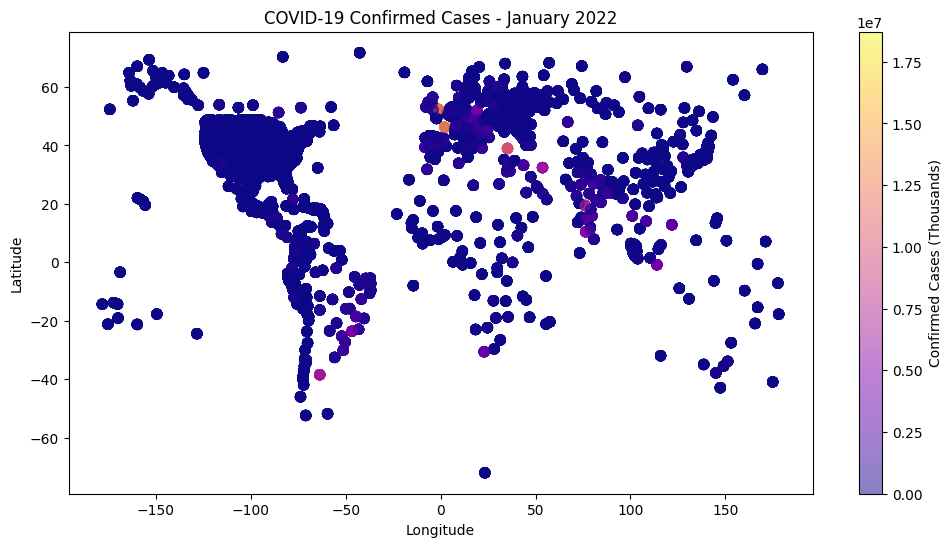

In [62]:
pandas_df = combined_df.toPandas()
pandas_df['confirmed'] = pd.to_numeric(pandas_df['confirmed'], errors='coerce')

plt.figure(figsize=(12, 6))
scatter = plt.scatter(pandas_df['long_'], pandas_df['lat'], c=pandas_df['confirmed'], cmap='plasma', alpha=0.5, s=50)
plt.title('COVID-19 Confirmed Cases - January 2022')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

cbar = plt.colorbar(scatter, label='Confirmed Cases (Thousands)')
cbar.set_label('Confirmed Cases (Thousands)') 

plt.show()

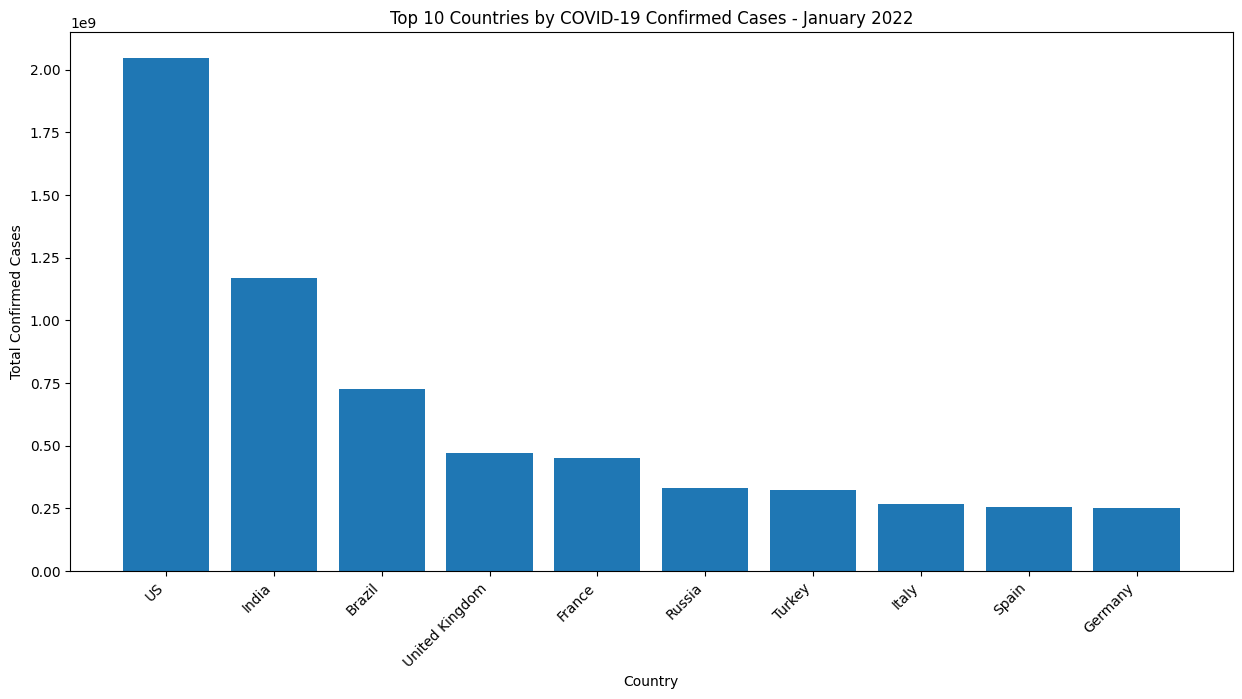

In [63]:
country_totals_df = combined_df.groupBy("country_region").agg(spark_sum("confirmed").alias("total_confirmed"))

country_totals_pandas_df = country_totals_df.toPandas()

# Sort and get the top 10 countries
top_10_countries = country_totals_pandas_df.sort_values(by='total_confirmed', ascending=False).head(10)

# Create a bar graph for the top 10 countries
plt.figure(figsize=(15, 7))
plt.bar(top_10_countries['country_region'], top_10_countries['total_confirmed'])
plt.xlabel('Country')
plt.ylabel('Total Confirmed Cases')
plt.title('Top 10 Countries by COVID-19 Confirmed Cases - January 2022')
plt.xticks(rotation=45, ha='right')
plt.show()

## What are the top 5 most common values in a particular column, and what is their frequency?

In [43]:
def top_values_analysis(column_name):
    """Calculates top 5 values and their frequencies for a column"""
    df_counts = combined_df.groupBy(column_name) \
                   .count() \
                   .sort(desc("count")) \
                   .limit(5)

    df_counts.show()

top_values_analysis("country_region") 


+--------------+------+
|country_region| count|
+--------------+------+
|            US|101649|
|        Russia|  2573|
|         Japan|  1519|
|         India|  1147|
|         China|  1054|
+--------------+------+



Top Occurrences: This output reveals the five countries that appear most frequently within the 'country_region' column of your COVID-19 dataset.
US Dominance: The "US" has by far the highest count, indicating it has significantly more data entries or reported cases compared to the other countries listed

## How does a particular metric change over time within the dataset?

In [56]:
def analyze_metric_over_time(metric_column, date_column="last_update"):
  """Analyzes how a metric changes over time (assumes dates)"""

  df_temp = combined_df.withColumn("date", date_format(col(date_column), "yyyy-MM-dd"))
  df_timeline = df_temp.groupBy("date").agg(avg(metric_column).alias("avg_" + metric_column))
  df_timeline.orderBy("date").show()

analyze_metric_over_time("confirmed") 

+----------+-----------------+
|      date|    avg_confirmed|
+----------+-----------------+
|2020-08-04|             76.0|
|2020-08-07|              0.0|
|2020-12-21|              2.6|
|2021-01-24|              0.0|
|2021-04-25|              0.0|
|2021-07-31|              0.0|
|2021-10-10|            434.0|
|2021-11-10|           3851.0|
|2021-12-19|4246.555555555556|
|2022-01-01|             54.0|
|2022-01-02|      72477.60825|
|2022-01-03|        72710.361|
|2022-01-04|        73294.885|
|2022-01-05|       73947.4555|
|2022-01-06|74575.53411647088|
|2022-01-07|75240.76130967258|
|2022-01-08|75979.76655836041|
|2022-01-09|76511.44388902774|
|2022-01-10|77408.48175912043|
|2022-01-11|77412.91652086978|
+----------+-----------------+
only showing top 20 rows



It actually increases

## Is there a correlation between two specific columns? Explain your findings.

In [47]:
def calculate_correlation(col1, col2):
    """Calculates correlation coefficient between two columns"""

    vector_col = "corr_features"

    # Cast columns to numeric type
    combined_df_numeric = combined_df.withColumn(col1, col(col1).cast("double")) \
                                     .withColumn(col2, col(col2).cast("double"))

    assembler = VectorAssembler(inputCols=[col1, col2], outputCol=vector_col)
    df_vector = assembler.transform(combined_df_numeric).select(vector_col) 
    correlation_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
    correlation = correlation_matrix.toArray()[0][1]

    print(f"Correlation between '{col1}' and '{col2}': {correlation:.3f}")
calculate_correlation("confirmed", "deaths")


Correlation between 'confirmed' and 'deaths': 0.864


Based on the analysis there is a moderately strong, positive correlation between confirmed cases and deaths. This suggests that as the number of confirmed cases increases, the number of deaths tends to increase as well